In [3]:
# script libraries
import data
# data handling
import pandas as pd
import numpy as np
# machine learning
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
# from tensorflow.keras.models import Model
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from hist import Hist
import hist
from tqdm import tqdm

In [4]:
# load in padded dataset
chonky_padded_waveforms = pd.read_parquet('padded_waveforms.parquet')

In [5]:
# us to timesteps
us2timesteps = 100

In [6]:
# convolution sizes
bigger_steps = np.flip(np.arange(14*us2timesteps, 26*us2timesteps, 2*us2timesteps))
print(bigger_steps)
big_steps = np.flip(np.arange(1*us2timesteps, 13*us2timesteps, us2timesteps))
med_steps = np.flip(np.arange(0.1*us2timesteps, 1*us2timesteps, 0.1*us2timesteps))
smol_steps = np.flip(np.arange(0.01*us2timesteps, 0.1*us2timesteps, 0.01*us2timesteps))
conv_sizes = np.concatenate((bigger_steps, big_steps, med_steps, smol_steps))
# print(conv_sizes)

[2400 2200 2000 1800 1600 1400]


In [7]:
# finalising the data arrays
padded_array = chonky_padded_waveforms['chonkers'].to_numpy()
x_data = np.stack(padded_array, axis=0)
# divide by max phd
max_phd = x_data.max()
x_data = x_data / max_phd
# set all values less than zero (probs due to noise) to zero. I think this is the correct way to do this?
x_data[x_data < 0] = 0
# waveform intensity range should now be between zero and 1.
print(x_data.min())
print(x_data.max())
print(x_data.shape)
y_data = chonky_padded_waveforms['label'].to_numpy().reshape((-1,1))
print(y_data.shape)
input_length = x_data.shape[-1]
print(input_length)

0.0
1.0
(7782, 3028)
(7782, 1)
3028


In [8]:
# get training and testing sets
runID = chonky_padded_waveforms['runID']
eventID = chonky_padded_waveforms['eventID']
W_array = chonky_padded_waveforms['weights_no_gas'].to_numpy()
X_train, X_test, \
y_train, y_test, \
W_train, W_test, \
runID_train, runID_test, \
eventID_train, eventID_test = \
train_test_split(x_data, y_data, W_array, runID, eventID, random_state=0)
print(X_train.shape)
print(y_train.shape)
print(X_train)
print(y_train)
X_train_reshaped = np.expand_dims(X_train, axis=-1)
print(X_train_reshaped.shape)

print(W_train.shape)

(5836, 3028)
(5836, 1)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[2]
 [2]
 [2]
 ...
 [1]
 [1]
 [1]]
(5836, 3028, 1)
(5836,)


In [9]:
# function to make a cnn
def one_layer_cnn_test(filter_size, num_filters=10, train_iters=20):
    CNN_model = keras.Sequential([
        keras.layers.Conv1D(filters=num_filters,kernel_size=filter_size,activation='relu', input_shape=(input_length, 1)),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')
    ])
    CNN_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                      loss='sparse_categorical_crossentropy',#'binary_crossentropy',
                      metrics=['accuracy'],
                      weighted_metrics=['accuracy'])
    CNN_model.fit(X_train,y_train,epochs=train_iters, validation_split=0.2, shuffle=True, sample_weight=W_train, verbose=0)
    test_loss, test_acc, test_weight_acc = CNN_model.evaluate(X_test,y_test, sample_weight=W_test)
    return test_loss, test_acc, test_weight_acc

# Test to check it works

In [8]:
# loss_lst = []
# acc_lst = []
# w_acc_lst = []
# for i in tqdm(range(len(conv_sizes))):
#     loss, acc, w_acc = one_layer_cnn_test(int(conv_sizes[i]))
#     loss_lst.append(loss_lst)
#     acc_lst.append(acc)
#     w_acc_lst.append(w_acc)

In [9]:
# plt.figure()
# plt.plot(conv_sizes / us2timesteps, w_acc_lst)
# plt.xlabel('filter sizes (us)')
# plt.ylabel('weighted accuracy')
# plt.title('10 convolutions in 1st layer')
# plt.xscale='log'
# plt.yscale='log'
# # plt.savefig('first_layer_10_convs.png')

# Full Test for first layer

In [10]:
filters = np.arange(4, 22, 2)

print(filters)
print()

loss_arr = np.zeros((len(filters), len(conv_sizes)))
acc_arr = np.zeros((len(filters), len(conv_sizes)))
w_acc_arr = np.zeros((len(filters), len(conv_sizes)))

[ 4  6  8 10 12 14 16 18 20]



In [11]:
i=0

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 1/9


  0%|          | 0/36 [00:00<?, ?it/s]2024-03-29 18:17:45.573561: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-29 18:17:45.573638: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-29 18:17:45.573664: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-29 18:17:45.574011: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-29 18:17:45.574258: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-29 18:17:46.259514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is ena

61/61 [==============================] - 1s 9ms/step - loss: 0.0131 - accuracy: 0.8700 - weighted_accuracy: 0.8921


  3%|▎         | 1/36 [00:55<32:11, 55.18s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0158 - accuracy: 0.8407 - weighted_accuracy: 0.8912


  6%|▌         | 2/36 [01:54<32:35, 57.51s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0176 - accuracy: 0.8710 - weighted_accuracy: 0.8597


  8%|▊         | 3/36 [02:57<33:07, 60.23s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0143 - accuracy: 0.8397 - weighted_accuracy: 0.8690


 11%|█         | 4/36 [04:05<33:45, 63.29s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0157 - accuracy: 0.8022 - weighted_accuracy: 0.8732


 14%|█▍        | 5/36 [05:15<33:57, 65.73s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0142 - accuracy: 0.8479 - weighted_accuracy: 0.8947


 17%|█▋        | 6/36 [06:21<32:56, 65.88s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0135 - accuracy: 0.8294 - weighted_accuracy: 0.8855


 19%|█▉        | 7/36 [07:27<31:48, 65.80s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0155 - accuracy: 0.8171 - weighted_accuracy: 0.8745


 22%|██▏       | 8/36 [08:31<30:23, 65.12s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0129 - accuracy: 0.8679 - weighted_accuracy: 0.8914


 25%|██▌       | 9/36 [09:35<29:06, 64.68s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0153 - accuracy: 0.8541 - weighted_accuracy: 0.8887


 28%|██▊       | 10/36 [10:35<27:26, 63.34s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0137 - accuracy: 0.8530 - weighted_accuracy: 0.8878


 31%|███       | 11/36 [11:32<25:39, 61.59s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0171 - accuracy: 0.8207 - weighted_accuracy: 0.8867


 33%|███▎      | 12/36 [12:30<24:05, 60.24s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0147 - accuracy: 0.8099 - weighted_accuracy: 0.8806


 36%|███▌      | 13/36 [13:22<22:14, 58.00s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0156 - accuracy: 0.8592 - weighted_accuracy: 0.8862


 39%|███▉      | 14/36 [14:11<20:13, 55.17s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0167 - accuracy: 0.8546 - weighted_accuracy: 0.8718


 42%|████▏     | 15/36 [14:53<17:54, 51.18s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0147 - accuracy: 0.8566 - weighted_accuracy: 0.8807


 44%|████▍     | 16/36 [15:33<15:53, 47.67s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.8150 - weighted_accuracy: 0.8749


 47%|████▋     | 17/36 [16:08<13:53, 43.87s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0185 - accuracy: 0.8279 - weighted_accuracy: 0.8698


 50%|█████     | 18/36 [16:39<11:59, 40.00s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.8094 - weighted_accuracy: 0.8575


 53%|█████▎    | 19/36 [17:10<10:36, 37.45s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.8530 - weighted_accuracy: 0.8640


 56%|█████▌    | 20/36 [17:42<09:32, 35.79s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.8258 - weighted_accuracy: 0.8740


 58%|█████▊    | 21/36 [18:13<08:36, 34.46s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0148 - accuracy: 0.7708 - weighted_accuracy: 0.8604


 61%|██████    | 22/36 [18:43<07:42, 33.04s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.8484 - weighted_accuracy: 0.8530


 64%|██████▍   | 23/36 [19:11<06:49, 31.46s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0333 - accuracy: 0.8078 - weighted_accuracy: 0.7671


 67%|██████▋   | 24/36 [19:38<06:03, 30.29s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0210 - accuracy: 0.8325 - weighted_accuracy: 0.8669


 69%|██████▉   | 25/36 [20:03<05:13, 28.52s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.8474 - weighted_accuracy: 0.8568


 72%|███████▏  | 26/36 [20:25<04:27, 26.74s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0201 - accuracy: 0.8217 - weighted_accuracy: 0.8635


 75%|███████▌  | 27/36 [20:46<03:44, 24.90s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.8022 - weighted_accuracy: 0.8494


 78%|███████▊  | 28/36 [21:07<03:08, 23.61s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0201 - accuracy: 0.7384 - weighted_accuracy: 0.7736


 81%|████████  | 29/36 [21:27<02:38, 22.58s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.8330 - weighted_accuracy: 0.8585


 83%|████████▎ | 30/36 [21:47<02:11, 21.84s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.7446 - weighted_accuracy: 0.8047


 86%|████████▌ | 31/36 [22:07<01:46, 21.31s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.7821 - weighted_accuracy: 0.8569


 89%|████████▉ | 32/36 [22:27<01:23, 20.90s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.7564 - weighted_accuracy: 0.7979


 92%|█████████▏| 33/36 [22:47<01:01, 20.61s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0207 - accuracy: 0.7744 - weighted_accuracy: 0.8550


 94%|█████████▍| 34/36 [23:07<00:40, 20.49s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0317 - accuracy: 0.7359 - weighted_accuracy: 0.8033


 97%|█████████▋| 35/36 [23:27<00:20, 20.34s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0301 - accuracy: 0.6860 - weighted_accuracy: 0.8062


100%|██████████| 36/36 [23:47<00:00, 39.66s/it]


In [12]:
i=1

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 2/9


  0%|          | 0/36 [00:00<?, ?it/s]

61/61 [==============================] - 1s 12ms/step - loss: 0.0136 - accuracy: 0.8700 - weighted_accuracy: 0.8847


  3%|▎         | 1/36 [01:00<35:00, 60.02s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0158 - accuracy: 0.8926 - weighted_accuracy: 0.8803


  6%|▌         | 2/36 [02:10<37:21, 65.93s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0290 - accuracy: 0.8284 - weighted_accuracy: 0.8674


  8%|▊         | 3/36 [03:20<37:25, 68.05s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0148 - accuracy: 0.8294 - weighted_accuracy: 0.8881


 11%|█         | 4/36 [04:36<37:57, 71.18s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0147 - accuracy: 0.8587 - weighted_accuracy: 0.8857


 14%|█▍        | 5/36 [05:54<38:05, 73.74s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0133 - accuracy: 0.8510 - weighted_accuracy: 0.8963


 17%|█▋        | 6/36 [07:09<36:59, 73.99s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0141 - accuracy: 0.8294 - weighted_accuracy: 0.8824


 19%|█▉        | 7/36 [08:25<36:03, 74.59s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0138 - accuracy: 0.8813 - weighted_accuracy: 0.8878


 22%|██▏       | 8/36 [09:35<34:14, 73.38s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0133 - accuracy: 0.8453 - weighted_accuracy: 0.8801


 25%|██▌       | 9/36 [10:46<32:40, 72.59s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0136 - accuracy: 0.8690 - weighted_accuracy: 0.8979


 28%|██▊       | 10/36 [11:54<30:46, 71.02s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0132 - accuracy: 0.8505 - weighted_accuracy: 0.8867


 31%|███       | 11/36 [12:56<28:30, 68.42s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0163 - accuracy: 0.8546 - weighted_accuracy: 0.8791


 33%|███▎      | 12/36 [13:58<26:30, 66.27s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0142 - accuracy: 0.8664 - weighted_accuracy: 0.8955


 36%|███▌      | 13/36 [14:57<24:36, 64.21s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0136 - accuracy: 0.8150 - weighted_accuracy: 0.8814


 39%|███▉      | 14/36 [15:50<22:16, 60.76s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0167 - accuracy: 0.8464 - weighted_accuracy: 0.8898


 42%|████▏     | 15/36 [16:40<20:09, 57.60s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0154 - accuracy: 0.8386 - weighted_accuracy: 0.8774


 44%|████▍     | 16/36 [17:25<17:56, 53.80s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0151 - accuracy: 0.8530 - weighted_accuracy: 0.8803


 47%|████▋     | 17/36 [18:05<15:43, 49.64s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0209 - accuracy: 0.8628 - weighted_accuracy: 0.8533


 50%|█████     | 18/36 [18:41<13:36, 45.37s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0178 - accuracy: 0.8088 - weighted_accuracy: 0.8670


 53%|█████▎    | 19/36 [19:18<12:12, 43.11s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0185 - accuracy: 0.8325 - weighted_accuracy: 0.8770


 56%|█████▌    | 20/36 [19:53<10:49, 40.57s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0177 - accuracy: 0.7595 - weighted_accuracy: 0.8532


 58%|█████▊    | 21/36 [20:29<09:45, 39.01s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0239 - accuracy: 0.8294 - weighted_accuracy: 0.8551


 61%|██████    | 22/36 [21:02<08:44, 37.44s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0204 - accuracy: 0.8453 - weighted_accuracy: 0.8536


 64%|██████▍   | 23/36 [21:33<07:42, 35.56s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0324 - accuracy: 0.7199 - weighted_accuracy: 0.7869


 67%|██████▋   | 24/36 [22:03<06:45, 33.80s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0220 - accuracy: 0.7847 - weighted_accuracy: 0.8587


 69%|██████▉   | 25/36 [22:31<05:50, 31.90s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.8412 - weighted_accuracy: 0.8487


 72%|███████▏  | 26/36 [22:56<04:58, 29.84s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.8232 - weighted_accuracy: 0.8330


 75%|███████▌  | 27/36 [23:18<04:08, 27.65s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.8345 - weighted_accuracy: 0.8509


 78%|███████▊  | 28/36 [23:40<03:27, 25.94s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.8464 - weighted_accuracy: 0.8436


 81%|████████  | 29/36 [24:02<02:52, 24.69s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.8566 - weighted_accuracy: 0.8468


 83%|████████▎ | 30/36 [24:24<02:23, 23.84s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0213 - accuracy: 0.8078 - weighted_accuracy: 0.8425


 86%|████████▌ | 31/36 [24:45<01:55, 23.19s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0235 - accuracy: 0.8088 - weighted_accuracy: 0.8424


 89%|████████▉ | 32/36 [25:07<01:30, 22.60s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0201 - accuracy: 0.8371 - weighted_accuracy: 0.8465


 92%|█████████▏| 33/36 [25:28<01:06, 22.24s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.8263 - weighted_accuracy: 0.8610


 94%|█████████▍| 34/36 [25:50<00:44, 22.03s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.7698 - weighted_accuracy: 0.8574


 97%|█████████▋| 35/36 [26:11<00:21, 21.83s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.7384 - weighted_accuracy: 0.7563


100%|██████████| 36/36 [26:32<00:00, 44.24s/it]


In [13]:
i=2

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 3/9


  0%|          | 0/36 [00:00<?, ?it/s]

61/61 [==============================] - 1s 14ms/step - loss: 0.0172 - accuracy: 0.8818 - weighted_accuracy: 0.8808


  3%|▎         | 1/36 [01:08<39:51, 68.32s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0167 - accuracy: 0.7950 - weighted_accuracy: 0.8639


  6%|▌         | 2/36 [02:10<36:43, 64.81s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0163 - accuracy: 0.8525 - weighted_accuracy: 0.8912


  8%|▊         | 3/36 [03:18<36:31, 66.41s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0136 - accuracy: 0.8464 - weighted_accuracy: 0.8939


 11%|█         | 4/36 [04:29<36:22, 68.19s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0143 - accuracy: 0.8294 - weighted_accuracy: 0.8857


 14%|█▍        | 5/36 [05:41<35:55, 69.52s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0152 - accuracy: 0.8386 - weighted_accuracy: 0.8862


 17%|█▋        | 6/36 [06:51<34:52, 69.74s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0133 - accuracy: 0.8422 - weighted_accuracy: 0.8922


 19%|█▉        | 7/36 [08:02<33:50, 70.02s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0130 - accuracy: 0.8597 - weighted_accuracy: 0.8907


 22%|██▏       | 8/36 [09:11<32:27, 69.56s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0143 - accuracy: 0.8587 - weighted_accuracy: 0.8955


 25%|██▌       | 9/36 [10:21<31:22, 69.73s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0155 - accuracy: 0.8669 - weighted_accuracy: 0.8858


 28%|██▊       | 10/36 [11:27<29:45, 68.69s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0155 - accuracy: 0.8741 - weighted_accuracy: 0.8881


 31%|███       | 11/36 [12:30<27:55, 67.04s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0156 - accuracy: 0.8700 - weighted_accuracy: 0.8810


 33%|███▎      | 12/36 [13:35<26:28, 66.17s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0154 - accuracy: 0.8284 - weighted_accuracy: 0.8851


 36%|███▌      | 13/36 [14:34<24:31, 63.99s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0165 - accuracy: 0.8022 - weighted_accuracy: 0.8738


 39%|███▉      | 14/36 [15:28<22:27, 61.24s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0190 - accuracy: 0.8499 - weighted_accuracy: 0.8544


 42%|████▏     | 15/36 [16:18<20:11, 57.71s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0173 - accuracy: 0.8541 - weighted_accuracy: 0.8683


 44%|████▍     | 16/36 [17:05<18:07, 54.35s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0158 - accuracy: 0.8232 - weighted_accuracy: 0.8819


 47%|████▋     | 17/36 [17:48<16:12, 51.18s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0186 - accuracy: 0.8222 - weighted_accuracy: 0.8702


 50%|█████     | 18/36 [18:23<13:53, 46.33s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0188 - accuracy: 0.8571 - weighted_accuracy: 0.8179


 53%|█████▎    | 19/36 [18:58<12:10, 42.96s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0179 - accuracy: 0.8325 - weighted_accuracy: 0.8789


 56%|█████▌    | 20/36 [19:34<10:53, 40.87s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0179 - accuracy: 0.7955 - weighted_accuracy: 0.8611


 58%|█████▊    | 21/36 [20:09<09:44, 38.98s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.8592 - weighted_accuracy: 0.8614


 61%|██████    | 22/36 [20:48<09:06, 39.05s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0200 - accuracy: 0.8073 - weighted_accuracy: 0.8630


 64%|██████▍   | 23/36 [21:19<07:56, 36.65s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.8258 - weighted_accuracy: 0.8754


 67%|██████▋   | 24/36 [21:49<06:53, 34.47s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0175 - accuracy: 0.8525 - weighted_accuracy: 0.8570


 69%|██████▉   | 25/36 [22:16<05:56, 32.42s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0265 - accuracy: 0.7914 - weighted_accuracy: 0.8509


 72%|███████▏  | 26/36 [22:42<05:04, 30.41s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0211 - accuracy: 0.7497 - weighted_accuracy: 0.8436


 75%|███████▌  | 27/36 [23:05<04:14, 28.23s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 0.8243 - weighted_accuracy: 0.8604


 78%|███████▊  | 28/36 [23:28<03:33, 26.63s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0218 - accuracy: 0.8602 - weighted_accuracy: 0.8401


 81%|████████  | 29/36 [23:51<02:58, 25.53s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0234 - accuracy: 0.8525 - weighted_accuracy: 0.8526


 83%|████████▎ | 30/36 [24:14<02:28, 24.83s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0222 - accuracy: 0.7724 - weighted_accuracy: 0.8528


 86%|████████▌ | 31/36 [24:37<02:01, 24.24s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0209 - accuracy: 0.7975 - weighted_accuracy: 0.8561


 89%|████████▉ | 32/36 [25:00<01:35, 23.77s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0325 - accuracy: 0.7508 - weighted_accuracy: 0.7813


 92%|█████████▏| 33/36 [25:22<01:10, 23.36s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0195 - accuracy: 0.8448 - weighted_accuracy: 0.8611


 94%|█████████▍| 34/36 [25:47<00:47, 23.87s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0192 - accuracy: 0.7770 - weighted_accuracy: 0.8584


 97%|█████████▋| 35/36 [26:09<00:23, 23.37s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0316 - accuracy: 0.7610 - weighted_accuracy: 0.7846


100%|██████████| 36/36 [26:32<00:00, 44.22s/it]


In [14]:
i=3

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 4/9


  0%|          | 0/36 [00:00<?, ?it/s]

61/61 [==============================] - 1s 18ms/step - loss: 0.0148 - accuracy: 0.8720 - weighted_accuracy: 0.8832


  3%|▎         | 1/36 [01:41<59:20, 101.73s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0154 - accuracy: 0.8350 - weighted_accuracy: 0.8788


  6%|▌         | 2/36 [03:38<1:02:32, 110.37s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0201 - accuracy: 0.8782 - weighted_accuracy: 0.8862


  8%|▊         | 3/36 [05:41<1:03:52, 116.14s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0139 - accuracy: 0.8592 - weighted_accuracy: 0.8916


 11%|█         | 4/36 [07:55<1:05:46, 123.32s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0191 - accuracy: 0.7528 - weighted_accuracy: 0.8306


 14%|█▍        | 5/36 [10:12<1:06:11, 128.10s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0129 - accuracy: 0.8433 - weighted_accuracy: 0.8934


 17%|█▋        | 6/36 [12:24<1:04:46, 129.55s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0163 - accuracy: 0.8808 - weighted_accuracy: 0.8812


 19%|█▉        | 7/36 [14:40<1:03:36, 131.61s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0170 - accuracy: 0.8458 - weighted_accuracy: 0.8846


 22%|██▏       | 8/36 [16:44<1:00:20, 129.32s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0140 - accuracy: 0.8520 - weighted_accuracy: 0.8955


 25%|██▌       | 9/36 [18:48<57:21, 127.46s/it]  

61/61 [==============================] - 1s 19ms/step - loss: 0.0121 - accuracy: 0.8628 - weighted_accuracy: 0.8975


 28%|██▊       | 10/36 [20:53<55:00, 126.94s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0141 - accuracy: 0.8582 - weighted_accuracy: 0.8822


 31%|███       | 11/36 [22:41<50:23, 120.96s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0152 - accuracy: 0.8165 - weighted_accuracy: 0.8833


 33%|███▎      | 12/36 [24:23<46:08, 115.36s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0187 - accuracy: 0.7595 - weighted_accuracy: 0.8609


 36%|███▌      | 13/36 [25:58<41:48, 109.08s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0160 - accuracy: 0.8366 - weighted_accuracy: 0.8876


 39%|███▉      | 14/36 [27:23<37:17, 101.71s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0165 - accuracy: 0.8803 - weighted_accuracy: 0.8840


 42%|████▏     | 15/36 [28:40<33:00, 94.30s/it] 

61/61 [==============================] - 1s 19ms/step - loss: 0.0165 - accuracy: 0.8684 - weighted_accuracy: 0.8541


 44%|████▍     | 16/36 [29:48<28:47, 86.38s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0198 - accuracy: 0.8325 - weighted_accuracy: 0.8565


 47%|████▋     | 17/36 [30:50<25:04, 79.20s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0182 - accuracy: 0.8535 - weighted_accuracy: 0.8737


 50%|█████     | 18/36 [31:45<21:31, 71.73s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0172 - accuracy: 0.8094 - weighted_accuracy: 0.8691


 53%|█████▎    | 19/36 [32:36<18:34, 65.57s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0180 - accuracy: 0.8577 - weighted_accuracy: 0.8704


 56%|█████▌    | 20/36 [33:25<16:09, 60.59s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0185 - accuracy: 0.7960 - weighted_accuracy: 0.8686


 58%|█████▊    | 21/36 [34:12<14:07, 56.53s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0175 - accuracy: 0.8068 - weighted_accuracy: 0.8660


 61%|██████    | 22/36 [34:54<12:12, 52.32s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0207 - accuracy: 0.7652 - weighted_accuracy: 0.8485


 64%|██████▍   | 23/36 [35:34<10:29, 48.41s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0176 - accuracy: 0.8515 - weighted_accuracy: 0.8656


 67%|██████▋   | 24/36 [36:11<09:02, 45.19s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0264 - accuracy: 0.8124 - weighted_accuracy: 0.8412


 69%|██████▉   | 25/36 [36:48<07:50, 42.78s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0194 - accuracy: 0.8088 - weighted_accuracy: 0.8597


 72%|███████▏  | 26/36 [37:22<06:39, 39.96s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0335 - accuracy: 0.6978 - weighted_accuracy: 0.7883


 75%|███████▌  | 27/36 [37:51<05:30, 36.67s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0226 - accuracy: 0.8350 - weighted_accuracy: 0.8548


 78%|███████▊  | 28/36 [38:20<04:34, 34.32s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0222 - accuracy: 0.7667 - weighted_accuracy: 0.8522


 81%|████████  | 29/36 [38:48<03:47, 32.46s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0221 - accuracy: 0.7795 - weighted_accuracy: 0.8569


 83%|████████▎ | 30/36 [39:17<03:08, 31.34s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0215 - accuracy: 0.7780 - weighted_accuracy: 0.8442


 86%|████████▌ | 31/36 [39:45<02:32, 30.51s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0252 - accuracy: 0.8217 - weighted_accuracy: 0.8544


 89%|████████▉ | 32/36 [40:14<02:00, 30.17s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0230 - accuracy: 0.8340 - weighted_accuracy: 0.8577


 92%|█████████▏| 33/36 [40:41<01:26, 28.96s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0249 - accuracy: 0.8237 - weighted_accuracy: 0.8534


 94%|█████████▍| 34/36 [41:07<00:56, 28.19s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0212 - accuracy: 0.8160 - weighted_accuracy: 0.8589


 97%|█████████▋| 35/36 [41:33<00:27, 27.45s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0296 - accuracy: 0.6881 - weighted_accuracy: 0.7929


100%|██████████| 36/36 [42:09<00:00, 70.28s/it]


In [21]:
np.save('losses', loss_arr)
np.save('accuracies', acc_arr)
np.save('weight_accuracies', w_acc_arr)

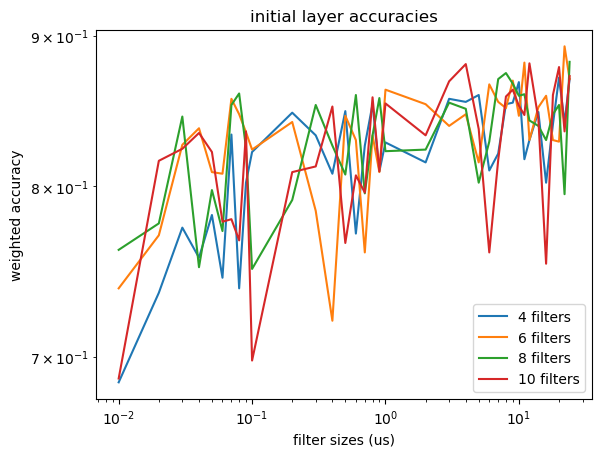

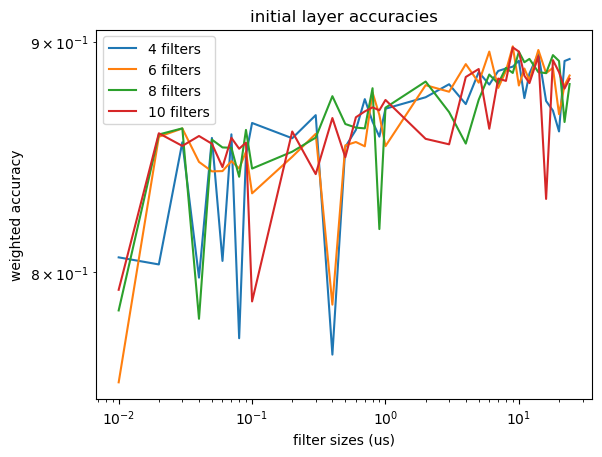

In [27]:
plt.figure()
plt.loglog(conv_sizes / us2timesteps, acc_arr[0], label='4 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[1], label='6 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[2], label='8 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[3], label='10 filters')
plt.xlabel('filter sizes (us)')
plt.ylabel('weighted accuracy')
plt.title('initial layer accuracies')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

plt.figure()
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[0], label='4 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[1], label='6 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[2], label='8 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[3], label='10 filters')
plt.xlabel('filter sizes (us)')
plt.ylabel('weighted accuracy')
plt.title('initial layer accuracies')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

In [15]:
# i=4

# print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
# for j in tqdm(range(len(conv_sizes))):
#     loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
#                                           num_filters=int(filters[i])
#                                           )
#     loss_arr[i, j] = loss
#     acc_arr[i, j] = acc
#     w_acc_arr[i, j] = w_acc

In [ ]:
# np.save('losses_i4', loss_arr)
# np.save('accuracies_i4', acc_arr)
# np.save('weight_accuracies_i4', w_acc_arr)

In [28]:
i=5

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 6/9


  0%|          | 0/36 [00:00<?, ?it/s]

61/61 [==============================] - 1s 21ms/step - loss: 0.0136 - accuracy: 0.8556 - weighted_accuracy: 0.8893


  3%|▎         | 1/36 [01:48<1:03:00, 108.01s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0150 - accuracy: 0.8720 - weighted_accuracy: 0.8761


  6%|▌         | 2/36 [03:47<1:05:01, 114.74s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0144 - accuracy: 0.8433 - weighted_accuracy: 0.8878


  8%|▊         | 3/36 [05:55<1:06:20, 120.63s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0176 - accuracy: 0.7662 - weighted_accuracy: 0.8488


 11%|█         | 4/36 [08:10<1:07:29, 126.55s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0144 - accuracy: 0.8628 - weighted_accuracy: 0.8975


 14%|█▍        | 5/36 [10:33<1:08:27, 132.51s/it]

61/61 [==============================] - 2s 28ms/step - loss: 0.0139 - accuracy: 0.8726 - weighted_accuracy: 0.8848


 17%|█▋        | 6/36 [14:42<1:26:05, 172.18s/it]

61/61 [==============================] - 2s 26ms/step - loss: 0.0151 - accuracy: 0.8839 - weighted_accuracy: 0.8731


 19%|█▉        | 7/36 [17:02<1:18:01, 161.43s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0133 - accuracy: 0.8577 - weighted_accuracy: 0.8734


 22%|██▏       | 8/36 [19:19<1:11:40, 153.60s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0165 - accuracy: 0.8834 - weighted_accuracy: 0.8744


 25%|██▌       | 9/36 [21:35<1:06:40, 148.15s/it]

61/61 [==============================] - 2s 25ms/step - loss: 0.0141 - accuracy: 0.8751 - weighted_accuracy: 0.8748


 28%|██▊       | 10/36 [23:40<1:01:05, 140.96s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0168 - accuracy: 0.8510 - weighted_accuracy: 0.8693


 31%|███       | 11/36 [25:33<55:12, 132.48s/it]  

61/61 [==============================] - 1s 22ms/step - loss: 0.0159 - accuracy: 0.8669 - weighted_accuracy: 0.8705


 33%|███▎      | 12/36 [27:26<50:34, 126.44s/it]

61/61 [==============================] - 2s 27ms/step - loss: 0.0137 - accuracy: 0.8587 - weighted_accuracy: 0.8839


 36%|███▌      | 13/36 [29:19<46:56, 122.46s/it]

61/61 [==============================] - 2s 27ms/step - loss: 0.0179 - accuracy: 0.8386 - weighted_accuracy: 0.8704


 39%|███▉      | 14/36 [34:54<1:08:29, 186.79s/it]

61/61 [==============================] - 2s 25ms/step - loss: 0.0176 - accuracy: 0.8566 - weighted_accuracy: 0.8802


 42%|████▏     | 15/36 [36:36<56:25, 161.19s/it]  

61/61 [==============================] - 2s 27ms/step - loss: 0.0172 - accuracy: 0.8515 - weighted_accuracy: 0.8913


 44%|████▍     | 16/36 [37:53<45:16, 135.81s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0153 - accuracy: 0.8756 - weighted_accuracy: 0.8787


 47%|████▋     | 17/36 [39:04<36:51, 116.38s/it]

61/61 [==============================] - 2s 30ms/step - loss: 0.0161 - accuracy: 0.8201 - weighted_accuracy: 0.8781


 50%|█████     | 18/36 [40:17<30:58, 103.27s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0159 - accuracy: 0.8520 - weighted_accuracy: 0.8816


 53%|█████▎    | 19/36 [41:20<25:50, 91.22s/it] 

61/61 [==============================] - 1s 22ms/step - loss: 0.0164 - accuracy: 0.8499 - weighted_accuracy: 0.8629


 56%|█████▌    | 20/36 [42:38<23:17, 87.33s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0182 - accuracy: 0.7945 - weighted_accuracy: 0.8561


 58%|█████▊    | 21/36 [43:48<20:28, 81.87s/it]

: 

In [ ]:
np.save('losses_i5', loss_arr)
np.save('accuracies_i5', acc_arr)
np.save('weight_accuracies_i5', w_acc_arr)

In [9]:
i=6

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 7/9


  0%|          | 0/36 [00:00<?, ?it/s]2024-03-29 22:11:25.259189: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-29 22:11:25.259216: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-29 22:11:25.259230: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-29 22:11:25.259494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-29 22:11:25.259773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-29 22:11:26.063885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is ena

61/61 [==============================] - 1s 15ms/step - loss: 0.0134 - accuracy: 0.8741 - weighted_accuracy: 0.8888


  3%|▎         | 1/36 [01:08<40:10, 68.87s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0202 - accuracy: 0.7739 - weighted_accuracy: 0.8496


  6%|▌         | 2/36 [02:26<41:56, 74.00s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0153 - accuracy: 0.8746 - weighted_accuracy: 0.8677


  8%|▊         | 3/36 [03:48<42:41, 77.62s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0153 - accuracy: 0.8135 - weighted_accuracy: 0.8798


 11%|█         | 4/36 [05:16<43:36, 81.77s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0137 - accuracy: 0.8556 - weighted_accuracy: 0.8873


 14%|█▍        | 5/36 [06:46<43:45, 84.69s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0136 - accuracy: 0.8561 - weighted_accuracy: 0.8884


 17%|█▋        | 6/36 [08:12<42:39, 85.32s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0144 - accuracy: 0.8597 - weighted_accuracy: 0.8841


 19%|█▉        | 7/36 [15:16<1:34:43, 195.97s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0178 - accuracy: 0.8895 - weighted_accuracy: 0.8680


 22%|██▏       | 8/36 [32:55<3:39:35, 470.56s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0162 - accuracy: 0.8453 - weighted_accuracy: 0.8883


 25%|██▌       | 9/36 [34:16<2:36:55, 348.74s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0139 - accuracy: 0.8299 - weighted_accuracy: 0.8834


 28%|██▊       | 10/36 [42:44<2:52:25, 397.91s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0161 - accuracy: 0.8227 - weighted_accuracy: 0.8757


 31%|███       | 11/36 [43:56<2:04:15, 298.22s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0159 - accuracy: 0.8525 - weighted_accuracy: 0.8855


 33%|███▎      | 12/36 [45:11<1:32:07, 230.32s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0174 - accuracy: 0.8803 - weighted_accuracy: 0.8485


 36%|███▌      | 13/36 [46:21<1:09:39, 181.73s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0165 - accuracy: 0.8607 - weighted_accuracy: 0.8814


 39%|███▉      | 14/36 [52:18<1:26:06, 234.84s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0168 - accuracy: 0.8669 - weighted_accuracy: 0.8892


 42%|████▏     | 15/36 [53:16<1:03:32, 181.53s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0148 - accuracy: 0.8494 - weighted_accuracy: 0.8872


 44%|████▍     | 16/36 [1:01:13<1:30:08, 270.43s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0175 - accuracy: 0.8217 - weighted_accuracy: 0.8721


 47%|████▋     | 17/36 [1:02:03<1:04:36, 204.00s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0164 - accuracy: 0.8453 - weighted_accuracy: 0.8713


 50%|█████     | 18/36 [1:02:43<46:26, 154.78s/it]  

61/61 [==============================] - 1s 8ms/step - loss: 0.0158 - accuracy: 0.8350 - weighted_accuracy: 0.8813


 53%|█████▎    | 19/36 [1:03:22<34:00, 120.00s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.7693 - weighted_accuracy: 0.8544


 56%|█████▌    | 20/36 [1:03:58<25:18, 94.89s/it] 

61/61 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.8417 - weighted_accuracy: 0.8750


 58%|█████▊    | 21/36 [1:04:34<19:17, 77.17s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.7724 - weighted_accuracy: 0.8605


 61%|██████    | 22/36 [1:10:10<36:07, 154.85s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0207 - accuracy: 0.8099 - weighted_accuracy: 0.8737


 64%|██████▍   | 23/36 [1:10:44<25:40, 118.51s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.8119 - weighted_accuracy: 0.8684


 67%|██████▋   | 24/36 [1:11:21<18:48, 94.01s/it] 

61/61 [==============================] - 0s 7ms/step - loss: 0.0179 - accuracy: 0.7939 - weighted_accuracy: 0.8578


 69%|██████▉   | 25/36 [1:11:54<13:55, 75.92s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.7888 - weighted_accuracy: 0.8600


 72%|███████▏  | 26/36 [1:12:26<10:24, 62.47s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.8371 - weighted_accuracy: 0.8640


 75%|███████▌  | 27/36 [1:12:53<07:48, 52.09s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.8058 - weighted_accuracy: 0.8595


 78%|███████▊  | 28/36 [1:13:21<05:56, 44.61s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0237 - accuracy: 0.8546 - weighted_accuracy: 0.8331


 81%|████████  | 29/36 [1:13:48<04:35, 39.40s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 0.8448 - weighted_accuracy: 0.8580


 83%|████████▎ | 30/36 [1:14:15<03:33, 35.65s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.8237 - weighted_accuracy: 0.8654


 86%|████████▌ | 31/36 [1:14:42<02:45, 33.19s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.8314 - weighted_accuracy: 0.8592


 89%|████████▉ | 32/36 [1:19:53<07:45, 116.42s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.8088 - weighted_accuracy: 0.8588


 92%|█████████▏| 33/36 [1:20:20<04:28, 89.59s/it] 

61/61 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.7703 - weighted_accuracy: 0.8452


 94%|█████████▍| 34/36 [1:20:47<02:21, 70.77s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.8392 - weighted_accuracy: 0.8604


 97%|█████████▋| 35/36 [1:21:14<00:57, 57.67s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0255 - accuracy: 0.8186 - weighted_accuracy: 0.8457


100%|██████████| 36/36 [1:21:41<00:00, 136.15s/it]


In [10]:
np.save('losses_i6', loss_arr)
np.save('accuracies_i6', acc_arr)
np.save('weight_accuracies_i6', w_acc_arr)

In [11]:
i=7

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 8/9


  0%|          | 0/36 [00:00<?, ?it/s]

61/61 [==============================] - 1s 22ms/step - loss: 0.0152 - accuracy: 0.8597 - weighted_accuracy: 0.8864


  3%|▎         | 1/36 [18:00<10:30:02, 1080.07s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0163 - accuracy: 0.8828 - weighted_accuracy: 0.8718


  6%|▌         | 2/36 [35:57<10:11:15, 1078.68s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0155 - accuracy: 0.8422 - weighted_accuracy: 0.8892


  8%|▊         | 3/36 [45:27<7:45:33, 846.48s/it]  

61/61 [==============================] - 1s 22ms/step - loss: 0.0157 - accuracy: 0.8546 - weighted_accuracy: 0.8904


 11%|█         | 4/36 [48:42<5:14:13, 589.17s/it]

61/61 [==============================] - 1s 24ms/step - loss: 0.0143 - accuracy: 0.8515 - weighted_accuracy: 0.8839


 14%|█▍        | 5/36 [1:06:29<6:33:25, 761.46s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0142 - accuracy: 0.8638 - weighted_accuracy: 0.8761


 17%|█▋        | 6/36 [1:09:36<4:42:58, 565.97s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0139 - accuracy: 0.8792 - weighted_accuracy: 0.8876


 19%|█▉        | 7/36 [1:12:46<3:34:12, 443.19s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0143 - accuracy: 0.8726 - weighted_accuracy: 0.8870


 22%|██▏       | 8/36 [1:15:42<2:47:04, 358.02s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0151 - accuracy: 0.8561 - weighted_accuracy: 0.8595


 25%|██▌       | 9/36 [1:18:39<2:15:43, 301.61s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0153 - accuracy: 0.8407 - weighted_accuracy: 0.8924


 28%|██▊       | 10/36 [1:21:28<1:52:52, 260.47s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0149 - accuracy: 0.8546 - weighted_accuracy: 0.8815


 31%|███       | 11/36 [1:23:58<1:34:28, 226.75s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0142 - accuracy: 0.8453 - weighted_accuracy: 0.8923


 33%|███▎      | 12/36 [1:26:25<1:20:57, 202.40s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0157 - accuracy: 0.8597 - weighted_accuracy: 0.8921


 36%|███▌      | 13/36 [1:28:38<1:09:32, 181.41s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0174 - accuracy: 0.8823 - weighted_accuracy: 0.8877


 39%|███▉      | 14/36 [1:30:31<59:00, 160.92s/it]  

61/61 [==============================] - 1s 16ms/step - loss: 0.0181 - accuracy: 0.7960 - weighted_accuracy: 0.8689


 42%|████▏     | 15/36 [1:32:14<50:12, 143.46s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0182 - accuracy: 0.8505 - weighted_accuracy: 0.8856


 44%|████▍     | 16/36 [1:33:40<42:01, 126.08s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0162 - accuracy: 0.8140 - weighted_accuracy: 0.8744


 47%|████▋     | 17/36 [1:34:47<34:15, 108.20s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0182 - accuracy: 0.8438 - weighted_accuracy: 0.8590


 50%|█████     | 18/36 [1:35:45<27:56, 93.14s/it] 

61/61 [==============================] - 1s 13ms/step - loss: 0.0171 - accuracy: 0.7888 - weighted_accuracy: 0.8624


 53%|█████▎    | 19/36 [1:36:47<23:46, 83.92s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0173 - accuracy: 0.8253 - weighted_accuracy: 0.8747


 56%|█████▌    | 20/36 [1:37:42<20:04, 75.29s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0162 - accuracy: 0.8453 - weighted_accuracy: 0.8849


 58%|█████▊    | 21/36 [1:38:38<17:23, 69.56s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0173 - accuracy: 0.8284 - weighted_accuracy: 0.8705


 61%|██████    | 22/36 [1:39:32<15:04, 64.63s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0175 - accuracy: 0.8145 - weighted_accuracy: 0.8739


 64%|██████▍   | 23/36 [1:40:21<13:00, 60.05s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0193 - accuracy: 0.8587 - weighted_accuracy: 0.8566


 67%|██████▋   | 24/36 [1:41:08<11:13, 56.12s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0190 - accuracy: 0.8556 - weighted_accuracy: 0.8580


 69%|██████▉   | 25/36 [1:41:50<09:29, 51.81s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0178 - accuracy: 0.8494 - weighted_accuracy: 0.8633


 72%|███████▏  | 26/36 [1:42:27<07:54, 47.50s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0193 - accuracy: 0.8058 - weighted_accuracy: 0.8535


 75%|███████▌  | 27/36 [1:43:04<06:38, 44.30s/it]

61/61 [==============================] - 0s 8ms/step - loss: 0.0213 - accuracy: 0.8129 - weighted_accuracy: 0.8562


 78%|███████▊  | 28/36 [1:43:40<05:33, 41.69s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0220 - accuracy: 0.8294 - weighted_accuracy: 0.8561


 81%|████████  | 29/36 [1:44:15<04:37, 39.70s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0250 - accuracy: 0.8397 - weighted_accuracy: 0.8344


 83%|████████▎ | 30/36 [1:44:50<03:50, 38.34s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0216 - accuracy: 0.8371 - weighted_accuracy: 0.8623


 86%|████████▌ | 31/36 [1:45:24<03:06, 37.24s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0198 - accuracy: 0.7816 - weighted_accuracy: 0.8527


 89%|████████▉ | 32/36 [1:45:58<02:24, 36.05s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0254 - accuracy: 0.8114 - weighted_accuracy: 0.8515


 92%|█████████▏| 33/36 [1:46:30<01:44, 34.94s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0224 - accuracy: 0.7456 - weighted_accuracy: 0.8435


 94%|█████████▍| 34/36 [1:47:02<01:08, 34.18s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0250 - accuracy: 0.7960 - weighted_accuracy: 0.8532


 97%|█████████▋| 35/36 [1:47:34<00:33, 33.39s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0264 - accuracy: 0.7369 - weighted_accuracy: 0.8459


100%|██████████| 36/36 [1:48:05<00:00, 180.17s/it]


In [12]:
np.save('losses_i7', loss_arr)
np.save('accuracies_i7', acc_arr)
np.save('weight_accuracies_i7', w_acc_arr)

In [13]:
i=8

print('Filter Size Number - ' + str(i+1) + '/' + str(len(filters)))
for j in tqdm(range(len(conv_sizes))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes[j]),
                                          num_filters=int(filters[i])
                                          )
    loss_arr[i, j] = loss
    acc_arr[i, j] = acc
    w_acc_arr[i, j] = w_acc

Filter Size Number - 9/9


  0%|          | 0/36 [00:00<?, ?it/s]

61/61 [==============================] - 1s 21ms/step - loss: 0.0155 - accuracy: 0.8556 - weighted_accuracy: 0.8897


  3%|▎         | 1/36 [02:20<1:22:07, 140.78s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0147 - accuracy: 0.8638 - weighted_accuracy: 0.8960


  6%|▌         | 2/36 [04:56<1:24:41, 149.44s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0179 - accuracy: 0.8376 - weighted_accuracy: 0.8904


  8%|▊         | 3/36 [07:41<1:26:06, 156.55s/it]

61/61 [==============================] - 1s 22ms/step - loss: 0.0168 - accuracy: 0.8654 - weighted_accuracy: 0.8909


 11%|█         | 4/36 [10:43<1:28:52, 166.63s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0132 - accuracy: 0.8731 - weighted_accuracy: 0.8840


 14%|█▍        | 5/36 [13:50<1:29:51, 173.92s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0155 - accuracy: 0.8607 - weighted_accuracy: 0.8835


 17%|█▋        | 6/36 [16:46<1:27:19, 174.64s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0147 - accuracy: 0.8731 - weighted_accuracy: 0.8825


 19%|█▉        | 7/36 [19:47<1:25:27, 176.80s/it]

61/61 [==============================] - 1s 21ms/step - loss: 0.0137 - accuracy: 0.8474 - weighted_accuracy: 0.8900


 22%|██▏       | 8/36 [22:34<1:21:04, 173.73s/it]

61/61 [==============================] - 1s 23ms/step - loss: 0.0139 - accuracy: 0.8623 - weighted_accuracy: 0.8922


 25%|██▌       | 9/36 [25:24<1:17:39, 172.59s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0157 - accuracy: 0.8654 - weighted_accuracy: 0.8925


 28%|██▊       | 10/36 [28:05<1:13:11, 168.92s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0151 - accuracy: 0.8638 - weighted_accuracy: 0.8942


 31%|███       | 11/36 [30:28<1:07:08, 161.12s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0157 - accuracy: 0.8592 - weighted_accuracy: 0.8781


 33%|███▎      | 12/36 [32:49<1:01:55, 154.82s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0145 - accuracy: 0.8464 - weighted_accuracy: 0.8873


 36%|███▌      | 13/36 [34:57<56:13, 146.69s/it]  

61/61 [==============================] - 1s 15ms/step - loss: 0.0163 - accuracy: 0.8499 - weighted_accuracy: 0.8805


 39%|███▉      | 14/36 [36:46<49:40, 135.48s/it]

61/61 [==============================] - 1s 19ms/step - loss: 0.0162 - accuracy: 0.8541 - weighted_accuracy: 0.8840


 42%|████▏     | 15/36 [38:26<43:40, 124.80s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0156 - accuracy: 0.8582 - weighted_accuracy: 0.8797


 44%|████▍     | 16/36 [39:50<37:29, 112.46s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0167 - accuracy: 0.8494 - weighted_accuracy: 0.8817


 47%|████▋     | 17/36 [40:58<31:24, 99.16s/it] 

61/61 [==============================] - 1s 14ms/step - loss: 0.0155 - accuracy: 0.8345 - weighted_accuracy: 0.8750


 50%|█████     | 18/36 [42:00<26:18, 87.72s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0157 - accuracy: 0.8443 - weighted_accuracy: 0.8750


 53%|█████▎    | 19/36 [42:58<22:21, 78.91s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0165 - accuracy: 0.8438 - weighted_accuracy: 0.8820


 56%|█████▌    | 20/36 [43:54<19:14, 72.16s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0164 - accuracy: 0.8232 - weighted_accuracy: 0.8782


 58%|█████▊    | 21/36 [44:50<16:46, 67.13s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0179 - accuracy: 0.8325 - weighted_accuracy: 0.8708


 61%|██████    | 22/36 [45:50<15:12, 65.15s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0172 - accuracy: 0.8345 - weighted_accuracy: 0.8743


 64%|██████▍   | 23/36 [46:39<13:03, 60.24s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0175 - accuracy: 0.8448 - weighted_accuracy: 0.8711


 67%|██████▋   | 24/36 [47:25<11:12, 56.07s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0190 - accuracy: 0.8032 - weighted_accuracy: 0.8610


 69%|██████▉   | 25/36 [48:07<09:29, 51.74s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0290 - accuracy: 0.8510 - weighted_accuracy: 0.7266


 72%|███████▏  | 26/36 [48:45<07:54, 47.49s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0203 - accuracy: 0.7518 - weighted_accuracy: 0.8394


 75%|███████▌  | 27/36 [49:23<06:43, 44.81s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0206 - accuracy: 0.7852 - weighted_accuracy: 0.8496


 78%|███████▊  | 28/36 [50:00<05:39, 42.44s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0204 - accuracy: 0.7996 - weighted_accuracy: 0.8564


 81%|████████  | 29/36 [50:38<04:47, 41.03s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0203 - accuracy: 0.8243 - weighted_accuracy: 0.8642


 83%|████████▎ | 30/36 [51:17<04:02, 40.33s/it]

61/61 [==============================] - 1s 11ms/step - loss: 0.0233 - accuracy: 0.7688 - weighted_accuracy: 0.8552


 86%|████████▌ | 31/36 [51:53<03:16, 39.32s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0224 - accuracy: 0.8592 - weighted_accuracy: 0.8362


 89%|████████▉ | 32/36 [52:28<02:31, 37.98s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0226 - accuracy: 0.8505 - weighted_accuracy: 0.8485


 92%|█████████▏| 33/36 [53:02<01:49, 36.60s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0211 - accuracy: 0.8320 - weighted_accuracy: 0.8667


 94%|█████████▍| 34/36 [53:35<01:11, 35.55s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0221 - accuracy: 0.8340 - weighted_accuracy: 0.8649


 97%|█████████▋| 35/36 [54:07<00:34, 34.65s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0281 - accuracy: 0.7945 - weighted_accuracy: 0.8329


100%|██████████| 36/36 [54:40<00:00, 91.13s/it]


In [14]:
np.save('losses_i8', loss_arr)
np.save('accuracies_i8', acc_arr)
np.save('weight_accuracies_i8', w_acc_arr)

In [20]:
print(loss_arr)

[[0.01313301 0.01576175 0.01755054 0.01434465 0.01569146 0.0142273
  0.01353201 0.01553156 0.01292848 0.0152932  0.01368149 0.01707757
  0.01468094 0.01561624 0.01674302 0.01466112 0.01916116 0.01852665
  0.01829972 0.01968588 0.02263309 0.01483327 0.02184713 0.03327966
  0.02096268 0.01947833 0.02013166 0.02750047 0.02009695 0.02164847
  0.03314843 0.0217915  0.03196231 0.02069139 0.03169686 0.03014128]
 [0.01357961 0.01584947 0.02904109 0.01481562 0.01470067 0.01333036
  0.01411456 0.01377578 0.01328851 0.01362514 0.01319259 0.01629316
  0.01421727 0.01363335 0.01668628 0.0153981  0.01505427 0.02089622
  0.01780084 0.01854925 0.01772463 0.02394017 0.02035918 0.03241944
  0.02199213 0.01927727 0.02284818 0.02255222 0.02144669 0.02170099
  0.02131915 0.02346515 0.02008571 0.01974304 0.02112773 0.02930127]
 [0.01717013 0.01672164 0.01632185 0.01360115 0.01428575 0.0151542
  0.01328347 0.01298138 0.01433954 0.01545645 0.01553521 0.01560584
  0.01537755 0.01650158 0.01901994 0.01726718 0.

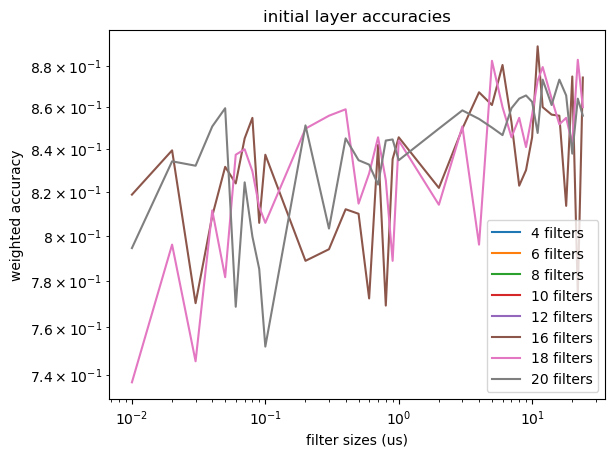

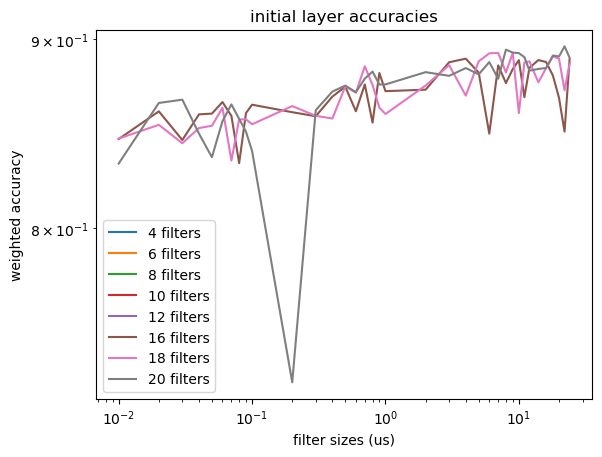

In [19]:
plt.figure()
plt.loglog(conv_sizes / us2timesteps, acc_arr[0], label='4 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[1], label='6 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[2], label='8 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[3], label='10 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[4], label='12 filters')
# plt.loglog(conv_sizes / us2timesteps, acc_arr[5], label='14 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[6], label='16 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[7], label='18 filters')
plt.loglog(conv_sizes / us2timesteps, acc_arr[8], label='20 filters')
plt.xlabel('filter sizes (us)')
plt.ylabel('weighted accuracy')
plt.title('initial layer accuracies')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

plt.figure()
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[0], label='4 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[1], label='6 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[2], label='8 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[3], label='10 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[4], label='12 filters')
# plt.loglog(conv_sizes / us2timesteps, w_acc_arr[5], label='14 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[6], label='16 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[7], label='18 filters')
plt.loglog(conv_sizes / us2timesteps, w_acc_arr[8], label='20 filters')
plt.xlabel('filter sizes (us)')
plt.ylabel('weighted accuracy')
plt.title('initial layer accuracies')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

### not much correlation in terms of number of filters, but looks like things improve as filter size increases

### going to keep increasing the filter size until things tail off

In [11]:
conv_sizes_wider = np.around(np.logspace(-2, 1.4, 30) * us2timesteps)
print(conv_sizes_wider[29])
num_filters_wider_test = 16

loss_list_wider = []
acc_list_wider = []
w_acc_list_wider = []

print('Number of Filters - ' + str(num_filters_wider_test))
for j in tqdm(range(len(conv_sizes_wider))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_sizes_wider[j]),
                                          num_filters=16
                                          )
    loss_list_wider.append(loss)
    acc_list_wider.append(acc)
    w_acc_list_wider.append(w_acc)

2512.0
Number of Filters - 10


  0%|          | 0/30 [00:00<?, ?it/s]2024-03-30 16:14:33.879648: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-30 16:14:33.879887: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-30 16:14:33.880297: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-30 16:14:33.880597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-30 16:14:33.881026: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-03-30 16:14:34.505893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is ena

61/61 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 0.8402 - weighted_accuracy: 0.8389


  3%|▎         | 1/30 [00:27<13:08, 27.20s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.7487 - weighted_accuracy: 0.8057


  7%|▋         | 2/30 [00:53<12:25, 26.61s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.8273 - weighted_accuracy: 0.8650


 10%|█         | 3/30 [01:19<11:48, 26.23s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.8309 - weighted_accuracy: 0.8573


 13%|█▎        | 4/30 [01:45<11:21, 26.22s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0206 - accuracy: 0.8474 - weighted_accuracy: 0.8420


 17%|█▋        | 5/30 [02:11<10:53, 26.16s/it]

61/61 [==============================] - 0s 6ms/step - loss: 0.0210 - accuracy: 0.8001 - weighted_accuracy: 0.8527


 20%|██        | 6/30 [02:37<10:26, 26.09s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.8402 - weighted_accuracy: 0.8618


 23%|██▎       | 7/30 [03:03<10:00, 26.12s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0225 - accuracy: 0.7739 - weighted_accuracy: 0.8578


 27%|██▋       | 8/30 [03:30<09:39, 26.33s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0186 - accuracy: 0.8006 - weighted_accuracy: 0.8610


 30%|███       | 9/30 [03:57<09:16, 26.52s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.8052 - weighted_accuracy: 0.8495


 33%|███▎      | 10/30 [04:25<09:01, 27.07s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.8392 - weighted_accuracy: 0.8615


 37%|███▋      | 11/30 [04:55<08:48, 27.83s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.7790 - weighted_accuracy: 0.8544


 40%|████      | 12/30 [05:24<08:31, 28.43s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.7975 - weighted_accuracy: 0.8661


 43%|████▎     | 13/30 [05:57<08:22, 29.57s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.8248 - weighted_accuracy: 0.8541


 47%|████▋     | 14/30 [06:30<08:13, 30.84s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.7842 - weighted_accuracy: 0.8610


 50%|█████     | 15/30 [07:05<08:00, 32.00s/it]

61/61 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.8253 - weighted_accuracy: 0.8690


 53%|█████▎    | 16/30 [07:39<07:34, 32.50s/it]

61/61 [==============================] - 1s 8ms/step - loss: 0.0158 - accuracy: 0.8273 - weighted_accuracy: 0.8749


 57%|█████▋    | 17/30 [08:17<07:25, 34.26s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0157 - accuracy: 0.8489 - weighted_accuracy: 0.8796


 60%|██████    | 18/30 [08:57<07:10, 35.90s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0147 - accuracy: 0.8325 - weighted_accuracy: 0.8875


 63%|██████▎   | 19/30 [09:42<07:04, 38.56s/it]

61/61 [==============================] - 1s 9ms/step - loss: 0.0137 - accuracy: 0.8392 - weighted_accuracy: 0.8849


 67%|██████▋   | 20/30 [10:32<07:00, 42.00s/it]

61/61 [==============================] - 1s 10ms/step - loss: 0.0157 - accuracy: 0.8366 - weighted_accuracy: 0.8865


 70%|███████   | 21/30 [11:25<06:47, 45.28s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0147 - accuracy: 0.8602 - weighted_accuracy: 0.8894


 73%|███████▎  | 22/30 [12:20<06:26, 48.30s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0156 - accuracy: 0.8489 - weighted_accuracy: 0.8872


 77%|███████▋  | 23/30 [13:18<05:59, 51.31s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.8443 - weighted_accuracy: 0.8817


 80%|████████  | 24/30 [14:20<05:25, 54.31s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0153 - accuracy: 0.8417 - weighted_accuracy: 0.8876


 83%|████████▎ | 25/30 [15:28<04:52, 58.45s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0143 - accuracy: 0.8207 - weighted_accuracy: 0.8854


 87%|████████▋ | 26/30 [16:41<04:12, 63.01s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0151 - accuracy: 0.8808 - weighted_accuracy: 0.8692


 90%|█████████ | 27/30 [18:04<03:26, 68.85s/it]

61/61 [==============================] - 1s 15ms/step - loss: 0.0156 - accuracy: 0.8489 - weighted_accuracy: 0.8798


 93%|█████████▎| 28/30 [19:30<02:27, 73.97s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0147 - accuracy: 0.8273 - weighted_accuracy: 0.8873


 97%|█████████▋| 29/30 [20:56<01:17, 77.74s/it]

61/61 [==============================] - 1s 14ms/step - loss: 0.0169 - accuracy: 0.8715 - weighted_accuracy: 0.8578


100%|██████████| 30/30 [22:01<00:00, 44.06s/it]


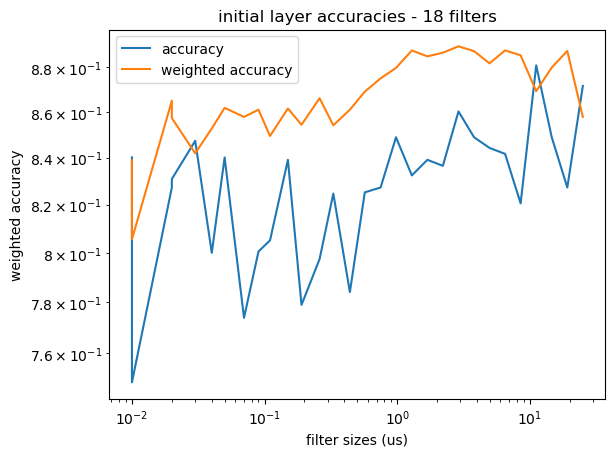

In [13]:
plt.figure()
plt.loglog(conv_sizes_wider / us2timesteps, acc_list_wider, label='accuracy')
plt.loglog(conv_sizes_wider / us2timesteps, w_acc_list_wider, label='weighted accuracy')
plt.xlabel('filter sizes (us)')
plt.ylabel('weighted accuracy')
plt.title('initial layer accuracies - 18 filters')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

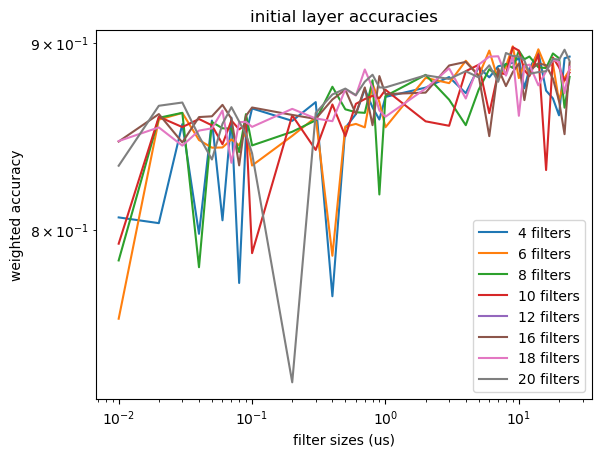

In [17]:
w_accs0to4 = np.load('weight_accuracies.npy')
w_accs6to8 = np.load('weight_accuracies_i8.npy')

plt.figure()
plt.loglog(conv_sizes / us2timesteps, w_accs0to4[0], label='4 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs0to4[1], label='6 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs0to4[2], label='8 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs0to4[3], label='10 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs0to4[4], label='12 filters')
# plt.loglog(conv_sizes / us2timesteps, w_acc_arr[5], label='14 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs6to8[6], label='16 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs6to8[7], label='18 filters')
plt.loglog(conv_sizes / us2timesteps, w_accs6to8[8], label='20 filters')
plt.xlabel('filter sizes (us)')
plt.ylabel('weighted accuracy')
plt.title('initial layer accuracies')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()

print()

### best looks like either 6 or 10 filters at 9us

In [38]:
print('best num filters - ' + str(np.where(w_accs0to4==w_accs0to4.max())))
print('max weighted accuracy - ' + str(w_accs0to4.max()))
print(w_accs0to4.max())
print(w_accs6to8.max())
print(np.where(w_accs0to4==w_accs0to4.max())[1][0])
print('best filter size - ' + str(conv_sizes[np.where(w_accs0to4==w_accs0to4.max())[1][0]] / us2timesteps) + 'us')
print(np.where(w_accs6to8==w_accs6to8.max()))
print()
# print('best filter size' + str(np.where(w_accs0to4.max())))

best num filters - (array([1]), array([9]))
max weighted accuracy - 0.8979435563087463
0.8979435563087463
0.8960312008857727
9
best filter size - 9.0us
(array([8]), array([1]))



In [40]:
# testing number of convolutions for 9us filter size

num_filters_big_range = np.around(np.logspace(0, 3, 25))
conv_size_big_range = 900

loss_list_big_range = []
acc_list_big_range = []
w_acc_list_big_range = []

print('Number of Filters - ' + str(num_filters_big_range))
for j in tqdm(range(len(num_filters_big_range))):
    loss, acc, w_acc = one_layer_cnn_test(filter_size=int(conv_size_big_range),
                                          num_filters=int(num_filters_big_range[j])
                                          )
    loss_list_big_range.append(loss)
    acc_list_big_range.append(acc)
    w_acc_list_big_range.append(w_acc)

Number of Filters - [   1.    1.    2.    2.    3.    4.    6.    7.   10.   13.   18.   24.
   32.   42.   56.   75.  100.  133.  178.  237.  316.  422.  562.  750.
 1000.]


  0%|          | 0/25 [00:00<?, ?it/s]

61/61 [==============================] - 1s 12ms/step - loss: 0.0164 - accuracy: 0.8376 - weighted_accuracy: 0.8878


  4%|▍         | 1/25 [01:09<27:40, 69.21s/it]

61/61 [==============================] - 1s 12ms/step - loss: 0.0194 - accuracy: 0.8284 - weighted_accuracy: 0.8604


  8%|▊         | 2/25 [02:17<26:17, 68.59s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0131 - accuracy: 0.8422 - weighted_accuracy: 0.8897


 12%|█▏        | 3/25 [03:29<25:47, 70.33s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0158 - accuracy: 0.8715 - weighted_accuracy: 0.8839


 16%|█▌        | 4/25 [04:40<24:37, 70.35s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0129 - accuracy: 0.8289 - weighted_accuracy: 0.8834


 20%|██        | 5/25 [05:52<23:41, 71.06s/it]

61/61 [==============================] - 1s 13ms/step - loss: 0.0153 - accuracy: 0.8767 - weighted_accuracy: 0.8716


 24%|██▍       | 6/25 [06:57<21:47, 68.84s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0146 - accuracy: 0.8854 - weighted_accuracy: 0.8864


 28%|██▊       | 7/25 [08:05<20:35, 68.63s/it]

61/61 [==============================] - 1s 16ms/step - loss: 0.0155 - accuracy: 0.8710 - weighted_accuracy: 0.8931


 32%|███▏      | 8/25 [09:18<19:49, 69.99s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0145 - accuracy: 0.8741 - weighted_accuracy: 0.8863


 36%|███▌      | 9/25 [11:12<22:23, 83.96s/it]

61/61 [==============================] - 1s 18ms/step - loss: 0.0137 - accuracy: 0.8669 - weighted_accuracy: 0.8858


 40%|████      | 10/25 [13:17<24:08, 96.56s/it]

61/61 [==============================] - 1s 20ms/step - loss: 0.0161 - accuracy: 0.8407 - weighted_accuracy: 0.8763


 44%|████▍     | 11/25 [16:05<27:37, 118.38s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0184 - accuracy: 0.8710 - weighted_accuracy: 0.8436


 48%|████▊     | 12/25 [18:43<28:14, 130.34s/it]

61/61 [==============================] - 1s 17ms/step - loss: 0.0143 - accuracy: 0.8582 - weighted_accuracy: 0.8872


 52%|█████▏    | 13/25 [20:47<25:43, 128.65s/it]

61/61 [==============================] - 2s 30ms/step - loss: 0.0153 - accuracy: 0.8376 - weighted_accuracy: 0.8886


 56%|█████▌    | 14/25 [25:43<32:50, 179.16s/it]

61/61 [==============================] - 2s 27ms/step - loss: 0.0156 - accuracy: 0.8145 - weighted_accuracy: 0.8792


 60%|██████    | 15/25 [30:30<35:15, 211.57s/it]

61/61 [==============================] - 4s 57ms/step - loss: 0.0153 - accuracy: 0.8690 - weighted_accuracy: 0.8914


 64%|██████▍   | 16/25 [41:15<51:17, 341.93s/it]

61/61 [==============================] - 3s 45ms/step - loss: 0.0144 - accuracy: 0.8613 - weighted_accuracy: 0.8956


 68%|██████▊   | 17/25 [50:39<54:30, 408.87s/it]

61/61 [==============================] - 6s 101ms/step - loss: 0.0142 - accuracy: 0.8700 - weighted_accuracy: 0.8889


 72%|███████▏  | 18/25 [1:09:54<1:13:50, 632.91s/it]

61/61 [==============================] - 5s 80ms/step - loss: 0.0165 - accuracy: 0.8402 - weighted_accuracy: 0.8793


 76%|███████▌  | 19/25 [1:24:00<1:09:41, 696.89s/it]

61/61 [==============================] - 8s 137ms/step - loss: 0.0155 - accuracy: 0.8777 - weighted_accuracy: 0.8894


 80%|████████  | 20/25 [3:11:49<3:22:30, 2430.16s/it]

61/61 [==============================] - 8s 125ms/step - loss: 0.0173 - accuracy: 0.8695 - weighted_accuracy: 0.8765


 84%|████████▍ | 21/25 [4:00:38<45:50, 687.56s/it]   


KeyboardInterrupt: 

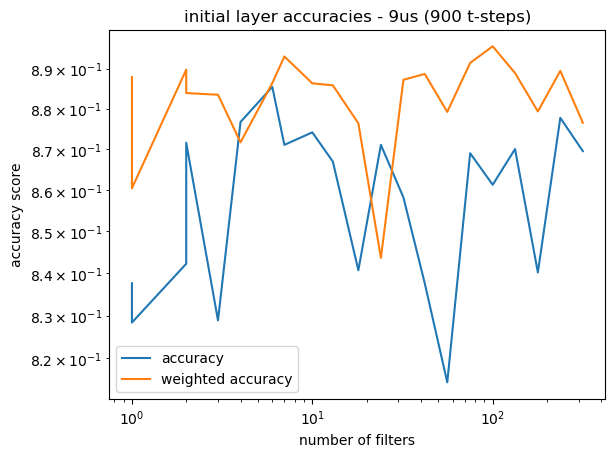

In [42]:
plt.figure()
plt.loglog(num_filters_big_range[:len(acc_list_big_range)], acc_list_big_range, label='accuracy')
plt.loglog(num_filters_big_range[:len(w_acc_list_big_range)], w_acc_list_big_range, label='weighted accuracy')
plt.xlabel('number of filters')
plt.ylabel('accuracy score')
plt.title('initial layer accuracies - 9us (900 t-steps)')
# plt.xscale='log'
# plt.yscale='log'
plt.legend()